In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Setup complete!")

Setup complete!


In [2]:
# Initialize DuckDB connection
conn = duckdb.connect()

# Configure DuckDB for S3 access
conn.execute("SET threads=100")
conn.execute("INSTALL httpfs")
conn.execute("LOAD httpfs")
conn.execute("""
    CREATE OR REPLACE SECRET s3 (
        TYPE S3,
        ENDPOINT 'minio.carlboettiger.info',
        URL_STYLE 'path',
        USE_SSL 'true',
        KEY_ID '',
        SECRET ''
    )
""")

# Test connection
result = conn.execute("SELECT 'Connection successful!' as status").fetchdf()
print("✅ DuckDB configured for S3 access")
print(result)

✅ DuckDB configured for S3 access
                   status
0  Connection successful!


In [3]:
def analyze_hydrobasins_for_country(country_code: str, country_name: str, top_n: int = 3) -> pd.DataFrame:
    """
    Analyze Level 6 HydroBASINS for a given country.
    
    Args:
        country_code: ISO 2-letter country code (e.g., 'US', 'CN')
        country_name: Full country name for display
        top_n: Number of top basins to return
        
    Returns:
        DataFrame with top hydrobasins and their scores
    """
    
    query = f"""
    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = '{country_code}' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon in wetlands
            ROUND(COALESCE(SUM(carb.carbon), 0), 2) as total_carbon,
            -- C. Protected wetland fraction
            ROUND(
                COUNT(DISTINCT CASE WHEN wdpa.h8 IS NOT NULL THEN bw.h8 END)::FLOAT / 
                NULLIF(COUNT(DISTINCT bw.h8), 0),
                3
            ) as protected_fraction,
            -- D. Average NCP score
            ROUND(AVG(ncp.ncp), 3) as avg_ncp_score
        FROM basin_wetlands bw
        LEFT JOIN read_parquet('s3://public-carbon/hex/vulnerable-carbon/**') carb 
            ON bw.h8 = carb.h8 AND bw.h0 = carb.h0
        LEFT JOIN read_parquet('s3://public-wdpa/hex/**') wdpa 
            ON bw.h8 = wdpa.h8 AND bw.h0 = wdpa.h0
        LEFT JOIN read_parquet('s3://public-ncp/hex/ncp_biod_nathab/**') ncp 
            ON bw.h8 = ncp.h8 AND bw.h0 = ncp.h0
        GROUP BY bw.basin_id, bw.PFAF_ID, bw.UP_AREA, bw.SUB_AREA
    )
    SELECT 
        basin_id,
        PFAF_ID,
        UP_AREA as upstream_area_km2,
        SUB_AREA as basin_area_km2,
        wetland_hex_count,
        wetland_area_hectares,
        total_carbon,
        protected_fraction,
        avg_ncp_score,
        -- Composite score (normalize each metric to 0-1 scale, then average)
        ROUND(
            (wetland_area_hectares / MAX(wetland_area_hectares) OVER () * 0.25 +
             total_carbon / NULLIF(MAX(total_carbon) OVER (), 0) * 0.25 +
             protected_fraction * 0.25 +
             avg_ncp_score * 0.25),
            3
        ) as composite_score
    FROM basin_metrics
    WHERE wetland_hex_count > 0
    ORDER BY composite_score DESC
    LIMIT {top_n};
    """
    
    print(f"\n{'='*80}")
    print(f"Analyzing: {country_name} ({country_code})")
    print(f"{'='*80}")
    
    # Execute query and get results as DataFrame
    df = conn.execute(query).fetchdf()
    
    if len(df) > 0:
        df['country'] = country_name
        df['country_code'] = country_code
        
        print(f"\nTop {top_n} Priority Hydrobasins in {country_name}:")
        print(df[[
            'basin_id', 'PFAF_ID', 'wetland_area_hectares', 'total_carbon', 
            'protected_fraction', 'avg_ncp_score', 'composite_score'
        ]].to_string(index=False))
    else:
        print(f"\nNo wetland data found for {country_name}")
        df['country'] = country_name
        df['country_code'] = country_code
    
    return df

## North America: United States, Canada, and Mexico

In [4]:
# United States
us_results = analyze_hydrobasins_for_country('US', 'United States', top_n=3)


Analyzing: United States (US)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in United States:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
7060044360   732573              988240.18   104702831.0               0.490          0.853            0.650
7060020790   783909             1052756.34    43764671.0               0.849          0.548            0.522
7060019450   783703              673180.10    23201061.0               0.916          0.595            0.477


In [5]:
# Canada
canada_results = analyze_hydrobasins_for_country('CA', 'Canada', top_n=3)


Analyzing: Canada (CA)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in Canada:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
7060022280   713300             2513918.45   107273425.0               0.129          0.848            0.622
7060023480   713535              504258.34    35544511.0               0.982          0.722            0.534
7060021750   711900             1520811.90    39927698.0               0.600          0.754            0.509


In [6]:
# Mexico
mexico_results = analyze_hydrobasins_for_country('MX', 'Mexico', top_n=3)


Analyzing: Mexico (MX)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in Mexico:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
7060051220   753715             4169440.10    69798685.0               0.278          0.740            0.754
7060055630   771000                3981.57           0.0               1.000          1.053            0.513
7060050610   753309               23889.41      483846.0               1.000          1.029            0.510


## Asia: China, South Korea, and Thailand

In [7]:
# China
china_results = analyze_hydrobasins_for_country('CN', 'China', top_n=3)


Analyzing: China (CN)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in China:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
4060154710   422499             3266213.79    24410238.0               0.081          0.154            0.559
4060213920   422416             2134563.40    17984046.0               0.007          0.535            0.483
4060006580   424901               51612.93      356741.0               0.843          1.023            0.474


In [8]:
# South Korea
korea_results = analyze_hydrobasins_for_country('KR', 'South Korea', top_n=3)


Analyzing: South Korea (KR)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in South Korea:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
4060005050   424200             1432185.13     4375953.0               0.280          0.805            0.769
4060003940   424102             1443318.77     2199144.0               0.088          0.203            0.448
4060004110   424105              668829.86     1000793.0               0.329          0.601            0.406


In [9]:
# Thailand
thailand_results = analyze_hydrobasins_for_country('TH', 'Thailand', top_n=3)


Analyzing: Thailand (TH)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in Thailand:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
4060021590   444077              683945.08    11754086.0               0.206          0.742            0.601
4060019420   444037             1360295.69     8266017.0               0.133          0.602            0.587
4060018360   444020              972166.44     5917277.0               0.449          0.598            0.550


## Europe: United Kingdom, France, and Spain

In [10]:
# United Kingdom
uk_results = analyze_hydrobasins_for_country('GB', 'United Kingdom', top_n=3)


Analyzing: United Kingdom (GB)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in United Kingdom:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
2060051160   233023             3736112.67    54955700.0               0.384          0.695            0.770
2060050420   233019              845862.22    24518796.0               0.570          0.924            0.542
2060049690   233017             1311337.13    28451190.0               0.371          0.687            0.482


In [11]:
# France
france_results = analyze_hydrobasins_for_country('FR', 'France', top_n=3)


Analyzing: France (FR)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in France:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
2060021230   232305              959631.87     7814810.0               0.258          0.505            0.691
2060502920   232240              778765.41     5727431.0               0.284          0.329            0.539
2060536370   216026              682544.16     3985500.0               0.365          0.502            0.522


In [12]:
# Spain
spain_results = analyze_hydrobasins_for_country('ES', 'Spain', top_n=3)


Analyzing: Spain (ES)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in Spain:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
2060018360   231201              831779.26     6304305.0               0.223          0.850            0.768
2060615620   216042              581751.47     5466492.0               0.312          0.547            0.606
2060598470   216049              467760.63     3294130.0               0.282          0.373            0.435


## South America: Brazil and Chile

In [13]:
# Brazil
brazil_results = analyze_hydrobasins_for_country('BR', 'Brazil', top_n=3)


Analyzing: Brazil (BR)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in Brazil:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
6060247260   622830             2736001.52   210847161.0               0.965          0.787            0.827
6060294360   622921             4927191.67   142572413.0               0.571          0.835            0.771
6060287830   622941             3724536.63   181332932.0               0.615          0.781            0.753


In [14]:
# Chile
chile_results = analyze_hydrobasins_for_country('CL', 'Chile', top_n=3)


Analyzing: Chile (CL)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in Chile:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
6060038660   661100             1725936.44    63933206.0               0.901          0.617            0.802
6060022920   661107             1907540.23    44721318.0               0.937          0.556            0.738
6060036010   661003             1066544.37    36350722.0               0.999          0.798            0.698


## Australia

In [15]:
# Australia
australia_results = analyze_hydrobasins_for_country('AU', 'Australia', top_n=3)


Analyzing: Australia (AU)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in Australia:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
5060077790   569001             2510379.27    95835397.0                0.51          0.819            0.832
5060062580   562540              330838.89     9224218.0                1.00          0.899            0.532
5060075600   565560                1105.99        2407.0                1.00          1.053            0.513


## India

In [16]:
# India
india_results = analyze_hydrobasins_for_country('IN', 'India', top_n=3)


Analyzing: India (IN)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in India:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
4060838850   452910             1032627.30    16171226.0                 0.0          0.802            0.501
4060048470   446000              534783.71    14458760.0                 0.0          0.908            0.477
4060865930   452700             1601770.47     8452995.0                 0.0          0.795            0.408


## Summary: Combined Results

In [17]:
# Combine all results
all_results = pd.concat([
    us_results, canada_results, mexico_results,
    china_results, korea_results, thailand_results,
    uk_results, france_results, spain_results,
    brazil_results, chile_results,
    australia_results, india_results
], ignore_index=True)

print("\n" + "="*80)
print("SUMMARY: Top Priority Hydrobasins Across All Countries")
print("="*80)
print(all_results[[
    'country', 'basin_id', 'PFAF_ID', 'wetland_area_hectares', 
    'total_carbon', 'protected_fraction', 'avg_ncp_score', 'composite_score'
]].to_string(index=False))

# Save to CSV
all_results.to_csv('priority_hydrobasins_results.csv', index=False)
print("\nResults saved to: priority_hydrobasins_results.csv")


SUMMARY: Top Priority Hydrobasins Across All Countries
       country   basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
 United States 7060044360   732573              988240.18   104702831.0               0.490          0.853            0.650
 United States 7060020790   783909             1052756.34    43764671.0               0.849          0.548            0.522
 United States 7060019450   783703              673180.10    23201061.0               0.916          0.595            0.477
        Canada 7060022280   713300             2513918.45   107273425.0               0.129          0.848            0.622
        Canada 7060023480   713535              504258.34    35544511.0               0.982          0.722            0.534
        Canada 7060021750   711900             1520811.90    39927698.0               0.600          0.754            0.509
        Mexico 7060051220   753715             4169440.10    69798685.0     

## Visualization: Comparative Analysis

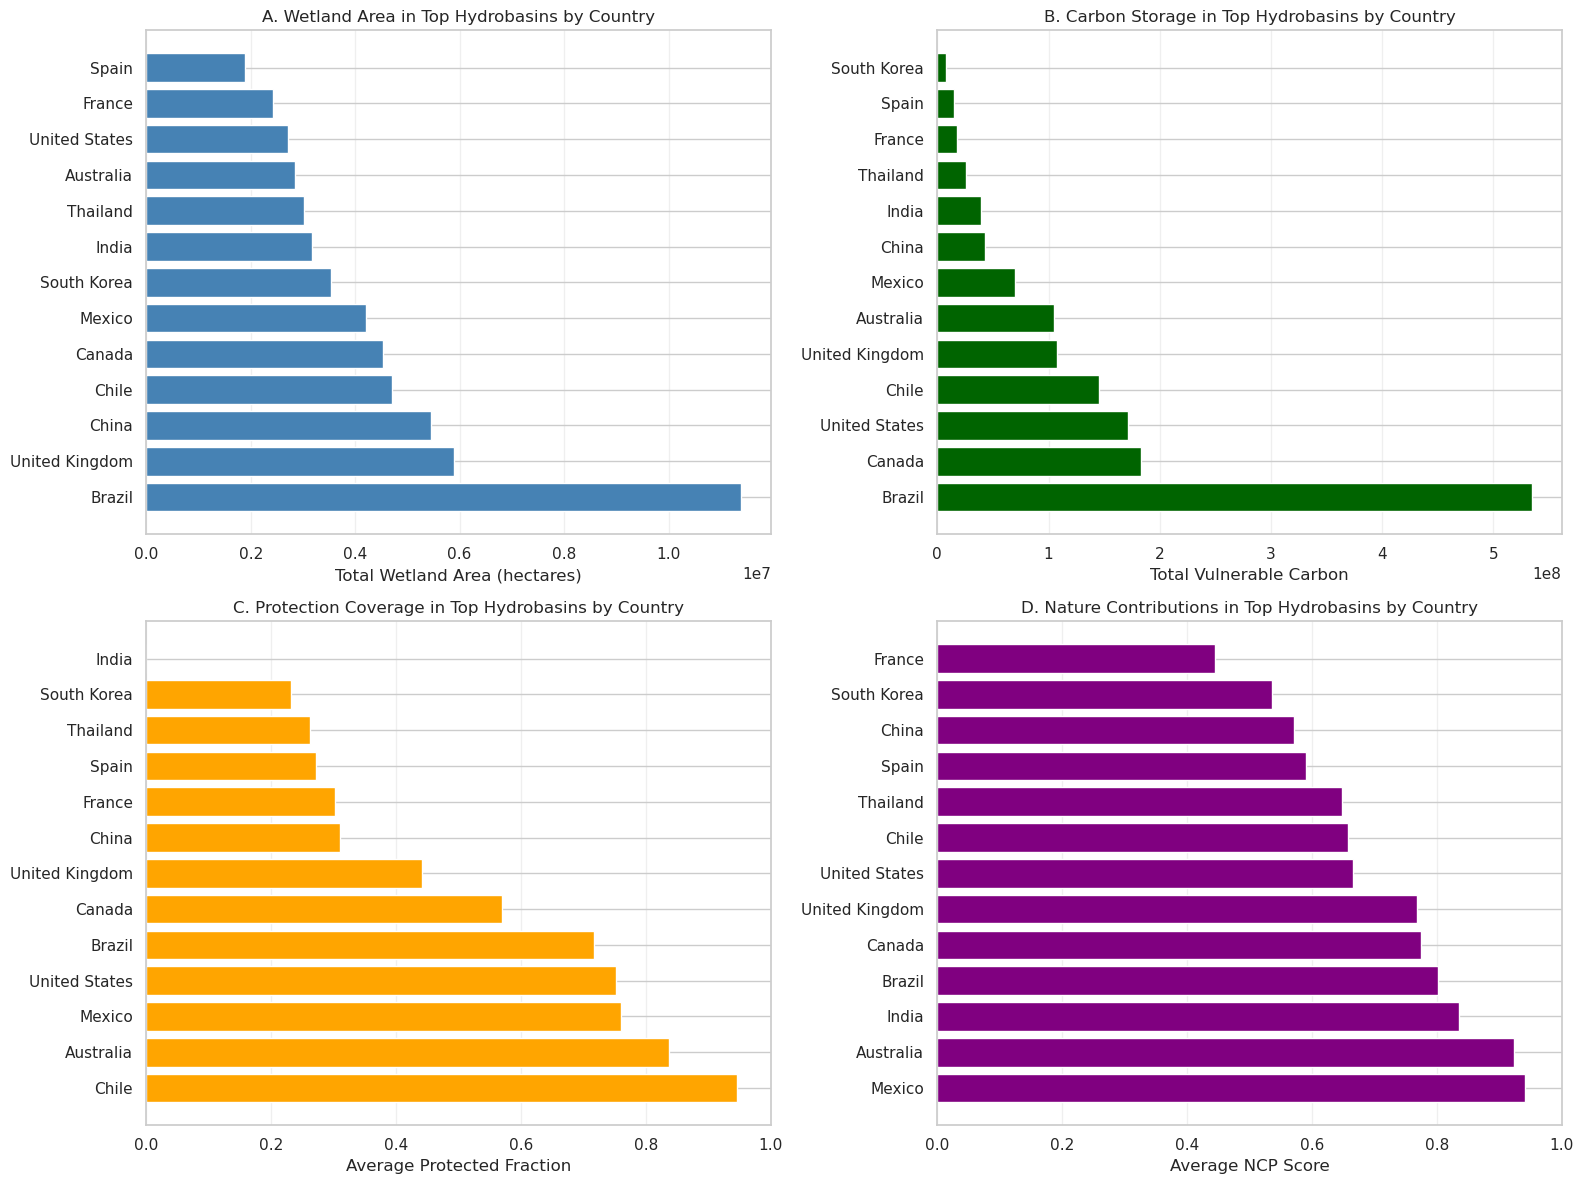

Visualization saved to: priority_hydrobasins_comparison.png


In [18]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A. Wetland Area by Country
country_totals = all_results.groupby('country')['wetland_area_hectares'].sum().sort_values(ascending=False)
axes[0, 0].barh(country_totals.index, country_totals.values, color='steelblue')
axes[0, 0].set_xlabel('Total Wetland Area (hectares)')
axes[0, 0].set_title('A. Wetland Area in Top Hydrobasins by Country')
axes[0, 0].grid(axis='x', alpha=0.3)

# B. Carbon Storage by Country
carbon_totals = all_results.groupby('country')['total_carbon'].sum().sort_values(ascending=False)
axes[0, 1].barh(carbon_totals.index, carbon_totals.values, color='darkgreen')
axes[0, 1].set_xlabel('Total Vulnerable Carbon')
axes[0, 1].set_title('B. Carbon Storage in Top Hydrobasins by Country')
axes[0, 1].grid(axis='x', alpha=0.3)

# C. Protected Fraction by Country
protected_avg = all_results.groupby('country')['protected_fraction'].mean().sort_values(ascending=False)
axes[1, 0].barh(protected_avg.index, protected_avg.values, color='orange')
axes[1, 0].set_xlabel('Average Protected Fraction')
axes[1, 0].set_title('C. Protection Coverage in Top Hydrobasins by Country')
axes[1, 0].set_xlim(0, 1)
axes[1, 0].grid(axis='x', alpha=0.3)

# D. NCP Score by Country
ncp_avg = all_results.groupby('country')['avg_ncp_score'].mean().sort_values(ascending=False)
axes[1, 1].barh(ncp_avg.index, ncp_avg.values, color='purple')
axes[1, 1].set_xlabel('Average NCP Score')
axes[1, 1].set_title('D. Nature Contributions in Top Hydrobasins by Country')
axes[1, 1].set_xlim(0, 1)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('priority_hydrobasins_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to: priority_hydrobasins_comparison.png")

/tmp/ipykernel_740273/35796866.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_results, x='country', y='composite_score', palette='Set2')


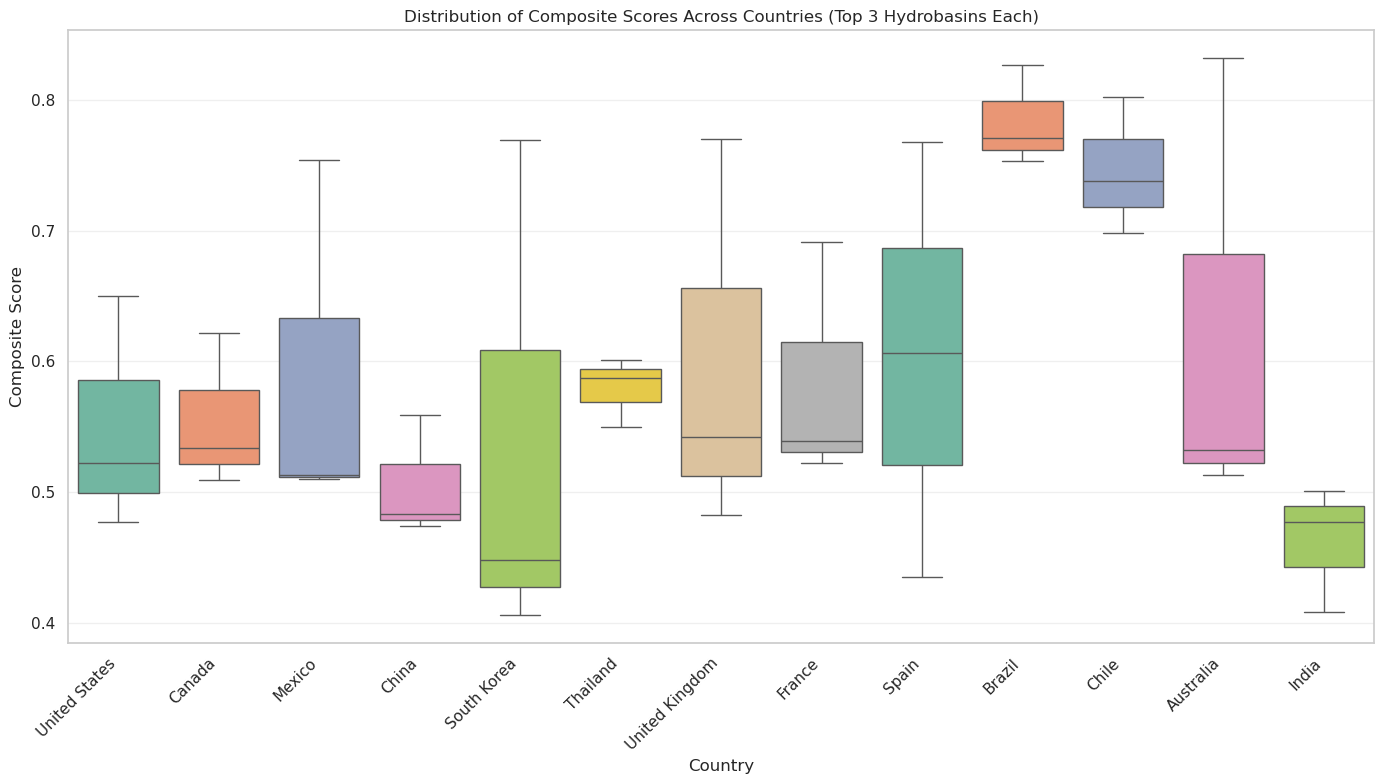

Composite score distribution saved to: composite_score_distribution.png


In [19]:
# Composite score comparison
plt.figure(figsize=(14, 8))
sns.boxplot(data=all_results, x='country', y='composite_score', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Country')
plt.ylabel('Composite Score')
plt.title('Distribution of Composite Scores Across Countries (Top 3 Hydrobasins Each)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('composite_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Composite score distribution saved to: composite_score_distribution.png")

## Key Findings

### Methodology

For each country, we identified the top 3 Level 6 HydroBASINS based on a composite score that equally weights four key metrics:

1. **Wetland Area (25%)**: Total hectares of wetlands from GLWD
2. **Carbon Storage (25%)**: Vulnerable carbon in wetlands
3. **Protection Status (25%)**: Fraction of wetlands within WDPA protected areas
4. **Nature's Contributions (25%)**: Average NCP biodiversity score

### Interpretation

The composite score helps identify hydrobasins that balance multiple conservation priorities:
- High wetland area indicates ecological significance
- High carbon storage suggests climate mitigation importance
- Low protection fraction highlights conservation gaps
- High NCP scores indicate biodiversity value and ecosystem services

### Next Steps

The results can be used to:
- Prioritize watersheds for conservation investment
- Identify protection gaps in high-value wetlands
- Support climate and biodiversity policy decisions
- Guide restoration and protection efforts